In [1]:
# torch with cpu-only support
! pip3 install torch==1.10.0+cpu torchvision==0.11.1+cpu -f https://download.pytorch.org/whl/cpu/torch_stable.html
# torch with gpu support
# ! pip3 install torch torchvision
! pip3 install matplotlib numpy torchsummary tqdm

Looking in links: https://download.pytorch.org/whl/cpu/torch_stable.html
     |████████████████████████████████| 199.3 MB 82 kB/s 
     |████████████████████████████████| 16.2 MB 510 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111


In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision
from PIL import Image

from tqdm import tqdm
from torchvision import transforms
from torchsummary import summary
from torch.utils.data import Dataset

# Load dataset
(https://www.kaggle.com/dhruvildave/english-handwritten-characters-dataset/version/3)

In [3]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])  # pixel value normalization
scale = transforms.Resize([224,224])  # image re-size (to square)
tote = transforms.ToTensor()   # transfor to tensor
comptran = transforms.Compose([scale,tote,normalize]) # put all transformations together

# apply transformations to images after loading

In [4]:
import pandas
import zipfile
import random

In [5]:
# Train, valid, test -> 33, 11, 11
# split given data, shuffle for training

with zipfile.ZipFile("archive.zip", 'r') as zip_ref:
    zip_ref.extractall()

data = pandas.read_csv("english.csv")
image_pathes = data.image
class_names = pandas.unique(data.label)

In [6]:
train_images = []
valid_images = []
test_images = []

for i in range(62):
  nums = [x for x in range(55)]
  random.shuffle(nums)
  for j in range(55):
    if j < 33:
      train_images.append(image_pathes[i*55 + nums[j]])
    elif j < 44:
      valid_images.append(image_pathes[i*55 + nums[j]])
    else:
      test_images.append(image_pathes[i*55 + nums[j]])

random.shuffle(train_images)

In [7]:
class EnglishDataset(Dataset):
    def __init__(self, image_paths):
        self.image_paths = image_paths
        self.transform = comptran
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        img = Image.open(image_filepath)
        
        label = int(image_filepath.split('/')[1][3:6]) - 1
        image = self.transform(img)
        # image = torch.unsqueeze(img, 0)
        
        return image, label

In [8]:
train_ds = EnglishDataset(train_images)
valid_ds = EnglishDataset(valid_images)
test_ds = EnglishDataset(test_images)

# Define the model

In [9]:
class AlexNet(torch.nn.Module):
  def __init__(self):
    super().__init__()
    c = 3
    num_class = 62
    self.convlayers = torch.nn.Sequential(
        torch.nn.Conv2d(c, 64, kernel_size=11, stride=4, padding=2),
        torch.nn.ReLU(inplace=True),
        torch.nn.MaxPool2d(kernel_size=3, stride=2),
        torch.nn.Conv2d(64, 192, kernel_size=5, padding=2),
        torch.nn.ReLU(inplace=True),
        torch.nn.MaxPool2d(kernel_size=3, stride=2),
        torch.nn.Conv2d(192, 384, kernel_size=3, padding=1),
        torch.nn.ReLU(inplace=True),
        torch.nn.Conv2d(384, 256, kernel_size=3, padding=1),
        torch.nn.ReLU(inplace=True),
        torch.nn.Conv2d(256, 256, kernel_size=3, padding=1),
        torch.nn.MaxPool2d(kernel_size=3, stride=2)
    )

    self.average = torch.nn.AdaptiveAvgPool2d(output_size=(6, 6))

    self.fc = torch.nn.Sequential(
        torch.nn.Dropout(),
        torch.nn.Linear(in_features=256*6*6, out_features=4096),
        torch.nn.ReLU(inplace=True),
        torch.nn.Dropout(),
        torch.nn.Linear(in_features=4096, out_features=4096),
        torch.nn.ReLU(inplace=True),
        torch.nn.Linear(in_features=4096, out_features=num_class)
    )

  def forward(self, x):
        x = self.convlayers(x)
        x = self.average(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [10]:
model = AlexNet()

In [11]:
input_size = (3, 224, 224)
summary(model, input_size=input_size, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
        MaxPool2d-12            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-13            [-1, 256, 6, 6]               0
          Dropout-14                 [-

# Training the model

In [12]:
device = 'cpu'
BATCH_SIZE = 64
EPOCHS = 20
LR = 0.0005

In [13]:
model.to(device)

AlexNet(
  (convlayers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (average): AdaptiveAvgPool2d(output_size=(6, 6))
  (fc): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3):

In [14]:
# define dataloaders
train_dataloader = torch.utils.data.DataLoader(
    train_ds, batch_size=BATCH_SIZE,
    shuffle=True, num_workers=2
)
valid_dataloader = torch.utils.data.DataLoader(
    valid_ds, batch_size=BATCH_SIZE,
    shuffle=False, num_workers=2
)
test_dataloader = torch.utils.data.DataLoader(
    test_ds, batch_size=BATCH_SIZE,
    shuffle=False, num_workers=2
)

In [15]:
batch = next(iter(train_dataloader))

In [16]:
# loss function and optimizer 
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = torch.nn.CrossEntropyLoss()

In [17]:
# metric
class AccuracyMetric:
    def __init__(self):
        self.correct, self.total = None, None
        self.reset()
        
    def update(self, y_pred, y_true):
        self.correct += torch.sum(y_pred.argmax(-1) == y_true).item()
        self.total += y_true.size(0)
        
    def compute(self):
        return self.correct / self.total
    
    def reset(self):
        self.correct = 0
        self.total = 0

In [20]:
# training loop
train_loss_history = []
train_accuracy_history = []

accuracy = AccuracyMetric()

for epoch in range(1, EPOCHS + 1):
    print(f'[INFO] Epoch: {epoch}')
    model.train()

    batch_train_loss = []

    
    for X_batch, y_batch in tqdm(train_dataloader):
        # perform single training step
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        
        accuracy.update(y_pred, y_batch)
        batch_train_loss.append(loss.item())

    mean_epoch_loss = np.mean(batch_train_loss)
    train_accuracy = accuracy.compute()
    
    train_loss_history.append(mean_epoch_loss)
    train_accuracy_history.append(train_accuracy)
    accuracy.reset()
    
    print(f'Train loss: {mean_epoch_loss:0.4f}, Accuracy: {train_accuracy: 0.4f}')

    model.eval()
    for X_batch, y_batch in tqdm(valid_dataloader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)

        accuracy.update(y_pred, y_batch)
    print(f'Validation Accuracy: {accuracy.compute()}')
    accuracy.reset()

[INFO] Epoch: 1


  0%|          | 0/32 [00:01<?, ?it/s]


KeyboardInterrupt: ignored

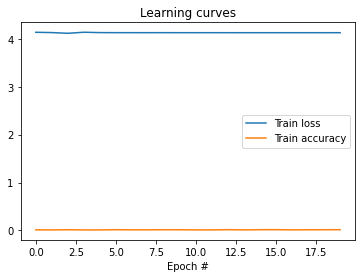

In [19]:
# plot learnign curve
plt.plot(train_loss_history)
plt.plot(train_accuracy_history)

plt.title('Learning curves')
plt.xlabel('Epoch #')
plt.legend(['Train loss', 'Train accuracy']);

# Evaluation

In [ ]:
model.eval()
with torch.no_grad():
    for X_batch, y_batch in tqdm(test_dataloader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)

        accuracy.update(y_pred, y_batch)
print(f'Test Accuracy: {accuracy.compute()}')

In [ ]:
X, Y_true, Y_pred = x.cpu(), y.cpu(), y_pred.argmax(-1).cpu()

In [ ]:
for i in range(len(X)):
  print("True: {}, predicted: {}".format(class_names[Y_pred[i]], class_names[Y_true[i]]))